## Import and wrangle data into a usable format

Code below to import the dataset and the libraries we need. 

In [197]:
import msoffcrypto
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import for dash app ## this is a trial...
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash_core_components as dcc

# Create an in-memory buffer
temp = io.BytesIO()

# Open the encrypted Excel file
with open('C:/Users/martin.bloyce2/OneDrive - NHS/Documents - Regional ' +
          'Analytics - South East/South East/Analysis/Diagnostics/Assets/' +
          '2023-24/imaging-assets-replacements/imaging-assets-replacement/' +
          'data/NIDC_South East_202324.xlsx', 'rb') as f:
    excel = msoffcrypto.OfficeFile(f)
    excel.load_key(password='Snidc24dow6')
    excel.decrypt(temp)

# Read the decrypted file into a pandas DataFrame
df = pd.read_excel(temp, sheet_name='3. Asset Register')

# Drop columns: '2023/2024 Part 1', 'CollectionName' and 6 other columns
df = df.drop(columns=['2023/2024 Part 1', 
                      'CollectionName', 
                      'RegionCode', 
                      'RegionName', 
                      'ReportingPeriodStart', 
                      'ReportingPeriodEnd', 
                      'SubmittedDatetime', 
                      'SubmissionStatus'])

df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Display the DataFrame
df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Mon_Fri,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1871 entries, 0 to 1870
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   OrganisationCode                1871 non-null   object        
 1   OrganisationName                1871 non-null   object        
 2   NIDC Asset ID                   1869 non-null   object        
 3   Local Equipment Identifier      1840 non-null   object        
 4   ODS Site Code                   1871 non-null   object        
 5   Location_Der                    1871 non-null   object        
 6   Machine_Type_Der                1871 non-null   object        
 7   Modality_Der                    1871 non-null   object        
 8   Equipment Detail Der            1865 non-null   object        
 9   Manufacture_Der                 1871 non-null   object        
 10  Date of Manufacture             1843 non-null   datetime64[ns]
 11  Age 

Bring in ods lookup

In [76]:
# load in file
etrust = pd.read_csv('C:/Users/martin.bloyce2/OneDrive - NHS/Documents - ' +
                     'Regional Analytics - South East/South East/Analysis/' +
                     'Diagnostics/Assets/2023-24/imaging-assets-replacements/' +
                     'imaging-assets-replacement/etrust.csv', 
                     header=None,
                     usecols=[0,1],
                     names=['ODS Site Code','name'])

# # convert to dictionary
etrust_dict = etrust.set_index('ODS Site Code')['name'].to_dict()

In [198]:
# merge to get site names
df = pd.merge(df, etrust, on='ODS Site Code', how='inner')

df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,FRIMLEY PARK HOSPITAL
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,ST MARK'S HOSPITAL
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,12.0,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL


In [199]:
# check cdc rows
df[df["name"].str.contains("CDC")]

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,Core_Operational_Hours_Sat,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name
18,RYR,University Hospitals Sussex NHS Foundation Trust,A240,BRMRI1,E8L5B,Community Diagnostic Centre Independent Sector...,Image Acquisition,MRI,Close Bore 1.5T,Siemens Healthcare,...,12.0,0.0,12.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,UNIVERSITY OF CHICHESTER BOGNOR CDC
23,RYR,University Hospitals Sussex NHS Foundation Trust,A239,SLMR1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,MRI,Close Bore 1.5T,Siemens Healthcare,...,12.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,1100000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
26,RYR,University Hospitals Sussex NHS Foundation Trust,A237,BRCT1,E8L5B,Community Diagnostic Centre Independent Sector...,Image Acquisition,CT,64 detector rows or more but less than 256 det...,Canon,...,0.0,0.0,0.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,UNIVERSITY OF CHICHESTER BOGNOR CDC
32,RHW,Royal Berkshire NHS Foundation Trust,A064,Aplioi 700 Bracknell Rm2,Y2X1G,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Canon,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,63600,In Service,Manufacturer provides maintenance,BRACKNELL HEALTHSPACE CDC
51,RYR,University Hospitals Sussex NHS Foundation Trust,A241,SLRAD1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,175000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
65,RHW,Royal Berkshire NHS Foundation Trust,A063,Samsung RS85 Prestige Bracknell Rm1,Y2X1G,Community Diagnostic Centre NHS Asset,Image Acquisition,Ultrasound,2D with CEUS / Elastography / Fusion Capabilit...,Samsung,...,0.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,97944,In Service,Asset Under Warranty,BRACKNELL HEALTHSPACE CDC
83,RYR,University Hospitals Sussex NHS Foundation Trust,A243,SLRAD3,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,150000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
84,RYR,University Hospitals Sussex NHS Foundation Trust,A242,SLRAD2,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,X ray Units Static,Plain X-Ray-DR Static,Siemens Healthcare,...,8.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,175000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC
113,RHU,Portsmouth Hospitals University National Healt...,A111,OAKP US,G2E0X,Community Diagnostic Centre Independent Sector...,Image Acquisition,Ultrasound,Ultrasound - General,Other,...,0.0,0.0,0.0,0.0,Independent Provider Asset,Independent Provider Asset,NaN,Independent Sector Asset,Independent Sector Asset,OAK PARK CDC
140,RYR,University Hospitals Sussex NHS Foundation Trust,A206,SLCT1,L6O9O,Community Diagnostic Centre NHS Asset,Image Acquisition,CT,256 detector rows or more with iterative recon...,Canon,...,12.0,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,900000,In Service,Manufacturer provides maintenance,SOUTHLANDS CDC


In [200]:
# flag for CDCs
df["type"] = df["name"].apply(lambda x: "CDC" if "CDC" in x else "non-CDC")

df.head()

,OrganisationCode,OrganisationName,NIDC Asset ID,Local Equipment Identifier,ODS Site Code,Location_Der,Machine_Type_Der,Modality_Der,Equipment Detail Der,Manufacture_Der,...,OOH_Operational_Hours_Sat,Core_Operational_Hours_Sun,OOH_Operational_Hours_Sun,Ownership Structure,Ownership_Structure_Der,Capital Purchase Cost,Asset Status,Maintenance Type_Der,name,type
0,RDU,Frimley Health NHS Foundation Trust,A160,G3132152,RDU01,Angiography Suite,Image Acquisition,Ultrasound,Ultrasound - General,Hitachi Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,FRIMLEY PARK HOSPITAL,non-CDC
1,RDU,Frimley Health NHS Foundation Trust,A159,E49106,RDU54,Imaging Department,Image Acquisition,Ultrasound,Ultrasound - General,GE Medical Systems,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,56704,In Service,Asset Under Warranty,ST MARK'S HOSPITAL,non-CDC
2,RDU,Frimley Health NHS Foundation Trust,A158,IPX039543,RDU52,Imaging Department,Image Acquisition,Dental,Intraoral,Xograph,...,0.0,12.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC
3,RDU,Frimley Health NHS Foundation Trust,A157,TRI2100460,RDU52,Imaging Department,Image Acquisition,X ray Units Mobile,Plain X-Ray-DR Mobile,Hologic,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,NaN,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC
4,RDU,Frimley Health NHS Foundation Trust,A156,3DM160700888,RDU52,Imaging Department,Image Acquisition,Mammography,Symptomatic - Digital Mammography 2D + 3D Tomo...,Hologic,...,0.0,0.0,0.0,Capital purchase - new,Capital purchase - new,403800,In Service,Asset Under Warranty,HEATHERWOOD HOSPITAL,non-CDC


Count of machine type by asset status

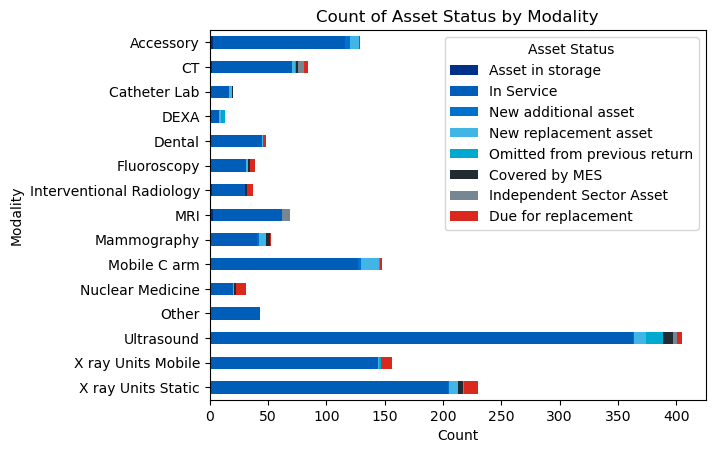

In [201]:
# Remove 'decommissioned'
count_data = df[df['Asset Status'] != "Decommissioned"]

# Count the occurrences
count_data = count_data.groupby(['Modality_Der', 'Asset Status']).size().unstack().fillna(0)

# NHS colour palette dictionary
nhs_colours = {
    'Asset in storage': '#003087', # NHS Dark Blue
    'Covered by MES': '#212b32', # black
    # 'Decommissioned': '#768692', # grey 1  ## no longer needed
    'Due for replacement': '#DA291C', # red
    'In Service': '#005EB8', # NHS Blue
    'Independent Sector Asset': '#768692', # grey 1
    'New additional asset': '#0072CE', # NHS Bright Blue
    'New replacement asset': '#41B6E6', # NHS Light Blue
    'Omitted from previous return': '#00A9CE' # NHS Aqua Blue
}

# Desired order of 'Asset Status'
desired_order = ['Asset in storage',
                 'In Service',
                 'New additional asset',
                 'New replacement asset',
                 'Omitted from previous return',
                 'Covered by MES',
                 'Independent Sector Asset',
                 'Due for replacement'
                ]

# Reindex the DataFrame to match the desired order
count_data = count_data.reindex(columns=desired_order)

# Plotting
count_data.plot(kind='barh', stacked=True, color=[nhs_colours[col] for col in count_data.columns])
plt.title('Count of Asset Status by Modality')
plt.xlabel('Count')
plt.ylabel('Modality')
plt.legend(title='Asset Status')
# Invert y-axis
plt.gca().invert_yaxis()
plt.show()

In [217]:
count_data

Asset Status,Asset in storage,In Service,New additional asset,New replacement asset,Omitted from previous return,Covered by MES,Independent Sector Asset,Due for replacement
Modality_Der,,,,,,,,
Accessory,3.0,113.0,4.0,8.0,0.0,0.0,0.0,1.0
CT,2.0,69.0,0.0,2.0,1.0,2.0,5.0,3.0
Catheter Lab,0.0,17.0,0.0,2.0,0.0,1.0,0.0,0.0
DEXA,1.0,7.0,0.0,2.0,3.0,0.0,0.0,0.0
Dental,0.0,45.0,0.0,1.0,0.0,0.0,0.0,2.0
Fluoroscopy,1.0,30.0,0.0,2.0,0.0,2.0,0.0,4.0
Interventional Radiology,2.0,28.0,0.0,0.0,0.0,2.0,0.0,5.0
MRI,3.0,59.0,0.0,0.0,0.0,0.0,7.0,0.0
Mammography,0.0,41.0,1.0,6.0,0.0,4.0,0.0,1.0


In [216]:
# trial with dash app...

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a list of tabs for each Modality_Der
tabs = []
modalities = sorted(df['Modality_Der'].unique())

for modality in modalities:
    df_modality = df[df['Modality_Der'] == modality]
    df_count = df_modality.groupby(['OrganisationName', 'type']).size().reset_index(name='count')
    
    # Calculate the percentage of "CDC"
    df_total = df_count.groupby('OrganisationName')['count'].sum().reset_index(name='total_count')
    df_cdc = df_count[df_count['type'] == 'CDC'].merge(df_total, on='OrganisationName')
    df_cdc['percentage'] = (df_cdc['count'] / df_cdc['total_count']) * 100
    
    # Create subplots with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add bar chart for counts
    for t in df_count['type'].unique():
        df_type = df_count[df_count['type'] == t]
        fig.add_trace(
            go.Bar(x=df_type['OrganisationName'], y=df_type['count'], name=t),
            secondary_y=False,
        )
    
    # Add line chart for percentage of "CDC"
    fig.add_trace(
        go.Scatter(x=df_cdc['OrganisationName'], y=df_cdc['percentage'], name='CDC %', mode='markers', line=dict(color='black')),
        secondary_y=True,
    )
    
    # Update layout
    fig.update_layout(
        title_text=f'Count of Assets by location type for {modality}',
        barmode='group',
        yaxis_title='Count',
        yaxis2_title='Percentage of CDC',
        legend_title='Type'
    )
    
    tabs.append(dcc.Tab(label=modality, children=[
        dcc.Graph(figure=fig)
    ]))

    # Write each to an HTML file
    fig.write_html(f"./{modality}_file.html")
    
# Define the layout of the app
app.layout = html.Div([
    dcc.Tabs(tabs)
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
# # Define the color palette with CDC as blue and non-CDC as orange
# colors = {'non-CDC': '#1f77b4', 'CDC': '#ff7f0e'}

# # Assuming 'Modality_Der' is a column in your DataFrame
# modalities = df['Modality_Der'].unique()

# for modality in modalities:
#     # Filter the DataFrame for the current modality
#     df_modality = df[df['Modality_Der'] == modality]
    
#     # Group by 'OrganisationName' and 'type', then count
#     count_cdc = df_modality.groupby(['OrganisationName', 'type']).size().unstack().fillna(0)
    
#     # # Ensure the columns are in the correct order
#     # count_cdc = count_cdc[['CDC', 'non-CDC']]
    
#     # Plotting
#     count_cdc.plot(kind='bar', stacked=True, color=colors)
#     plt.title(f'Count of Assets by location type for {modality}')
#     plt.xlabel('Org Name')
#     plt.ylabel('Count')
#     plt.legend(title='Location Type')
#     plt.show()

Scatterplot count of modality vs avg age of asset, by provider

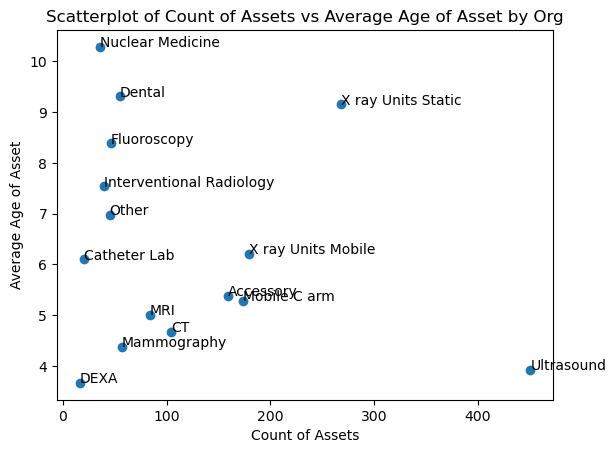

In [191]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Group by OrganisationName to get the count and average age_of_asset
grouped_df = df.groupby('Modality_Der').agg(
    count_modality=('Modality_Der', 'count'),
    avg_age_of_asset=('Age', 'mean')
).reset_index()


# Create a scatter plot
plt.scatter(grouped_df['count_modality'], grouped_df['avg_age_of_asset'])

# Add labels and title
plt.xlabel('Count of Assets')
plt.ylabel('Average Age of Asset')
plt.title('Scatterplot of Count of Assets vs Average Age of Asset by Org')

# Label dots with OrganisationName
for i, row in grouped_df.iterrows():
    plt.text(row['count_modality'], row['avg_age_of_asset'], row['Modality_Der'])

# Show the plot
plt.show()

Asset type by age

Replacement schedule and cost dictionaries

In [81]:
import numpy as np

replacement_schedule = {
'Accessory': 5,
'CT': 8,
'Catheter Lab': 8,
'DEXA': 10,
'Dental': 10,
'Fluoroscopy': 8,
'Interventional Radiology': 8,
'MRI': 8,
'Mammography': 5,
'Mobile C arm': 8,
'Nuclear Medicine': 8,
'Other': 0,
'Ultrasound': 5,
'X ray Units Mobile': 8,
'X ray Units Static': 8,
}

replacement_cost = {
'Accessory': 25000,
'CT': 850000,
'Catheter Lab': 1000000,
'DEXA': 950000,
'Dental': 45000,
'Fluoroscopy': 800000,
'Interventional Radiology': 1000000,
'MRI': 1200000,
'Mammography': 400000,
'Mobile C arm': 95000,
'Nuclear Medicine': 900000,
'Other': np.nan,
'Ultrasound': 90000,
'X ray Units Mobile': 90000,
'X ray Units Static': 125000,
}

Stacked bar chart by provider

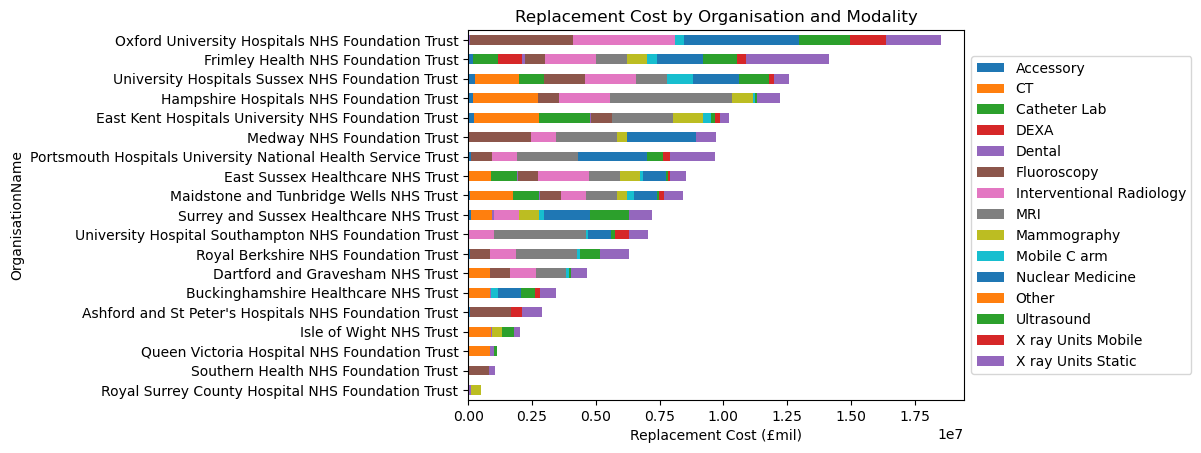

In [180]:
# remove decommissioned assets
df = df[df['Asset Status'] != 'Decommissioned']

# Add replacement_cost to the DataFrame
df['replacement_cost'] = df.apply(lambda row: replacement_cost[(row['Modality_Der'])], axis=1)
df['replacement_schedule'] = df.apply(lambda row: replacement_schedule[(row['Modality_Der'])], axis=1)


# Only where Age > replacement_schedule
outdated_assets = df[df['Age'] > df['replacement_schedule']]

# Pivot the DataFrame to get the data in the format required for a stacked bar chart
pivot_df = outdated_assets.pivot_table(index='OrganisationName', columns='Modality_Der', values='replacement_cost', aggfunc='sum').fillna(0)

# Calculate the total replacement cost per organisation
pivot_df['Total'] = pivot_df.sum(axis=1)

# Sort by total replacement cost
pivot_df = pivot_df.sort_values('Total', ascending=False).drop('Total', axis=1)

# Create a stacked bar chart
pivot_df.plot(kind='barh', stacked=True)

# Add labels and title
plt.xlabel('Replacement Cost (£mil)')
plt.ylabel('OrganisationName')
plt.title('Replacement Cost by Organisation and Modality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Invert y-axis
plt.gca().invert_yaxis()

# Show the plot
plt.show()

In [181]:
# Calculate row and column totals
pivot_df.loc['Total'] = pivot_df.sum()
pivot_df['Total'] = pivot_df.sum(axis=1)

# Ensure the DataFrame has numeric values only
pivot_df = pivot_df.apply(pd.to_numeric)

# Change format to look like currency
pivot_df = pivot_df.applymap(lambda x: "£{:,.0f}".format(x))

pivot_df

C:\Users\local_martin.bloyce2\Temp\ipykernel_18488\3575831422.py:9: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Modality_Der,Accessory,CT,Catheter Lab,DEXA,Dental,Fluoroscopy,Interventional Radiology,MRI,Mammography,Mobile C arm,Nuclear Medicine,Other,Ultrasound,X ray Units Mobile,X ray Units Static,Total
OrganisationName,,,,,,,,,,,,,,,,
Oxford University Hospitals NHS Foundation Trust,£0,£0,£0,£0,"£90,000","£4,000,000","£4,000,000",£0,£0,"£380,000","£4,500,000",£0,"£1,980,000","£1,440,000","£2,125,000","£18,515,000"
Frimley Health NHS Foundation Trust,"£175,000",£0,"£1,000,000","£950,000","£90,000","£800,000","£2,000,000","£1,200,000","£800,000","£380,000","£1,800,000",£0,"£1,350,000","£360,000","£3,250,000","£14,155,000"
University Hospitals Sussex NHS Foundation Trust,"£275,000","£1,700,000","£1,000,000",£0,£0,"£1,600,000","£2,000,000","£1,200,000",£0,"£1,045,000","£1,800,000",£0,"£1,170,000","£180,000","£625,000","£12,595,000"
Hampshire Hospitals NHS Foundation Trust,"£200,000","£2,550,000",£0,£0,£0,"£800,000","£2,000,000","£4,800,000","£800,000","£95,000",£0,£0,"£90,000",£0,"£875,000","£12,210,000"
East Kent Hospitals University NHS Foundation Trust,"£225,000","£2,550,000","£2,000,000",£0,"£45,000","£800,000",£0,"£2,400,000","£1,200,000","£285,000",£0,£0,"£180,000","£180,000","£375,000","£10,240,000"
Medway NHS Foundation Trust,£0,£0,£0,£0,"£45,000","£2,400,000","£1,000,000","£2,400,000","£400,000",£0,"£2,700,000",£0,£0,£0,"£750,000","£9,695,000"
Portsmouth Hospitals University National Health Service Trust,"£125,000",£0,£0,£0,£0,"£800,000","£1,000,000","£2,400,000",£0,£0,"£2,700,000",£0,"£630,000","£270,000","£1,750,000","£9,675,000"
East Sussex Healthcare NHS Trust,"£50,000","£850,000","£1,000,000",£0,"£45,000","£800,000","£2,000,000","£1,200,000","£800,000","£95,000","£900,000",£0,"£90,000","£90,000","£625,000","£8,545,000"
Maidstone and Tunbridge Wells NHS Trust,"£75,000","£1,700,000","£1,000,000",£0,"£45,000","£800,000","£1,000,000","£1,200,000","£400,000","£285,000","£900,000",£0,"£90,000","£180,000","£750,000","£8,425,000"


Boxplot to show age of asset by modality

C:\Users\local_martin.bloyce2\Temp\ipykernel_18488\2485505417.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



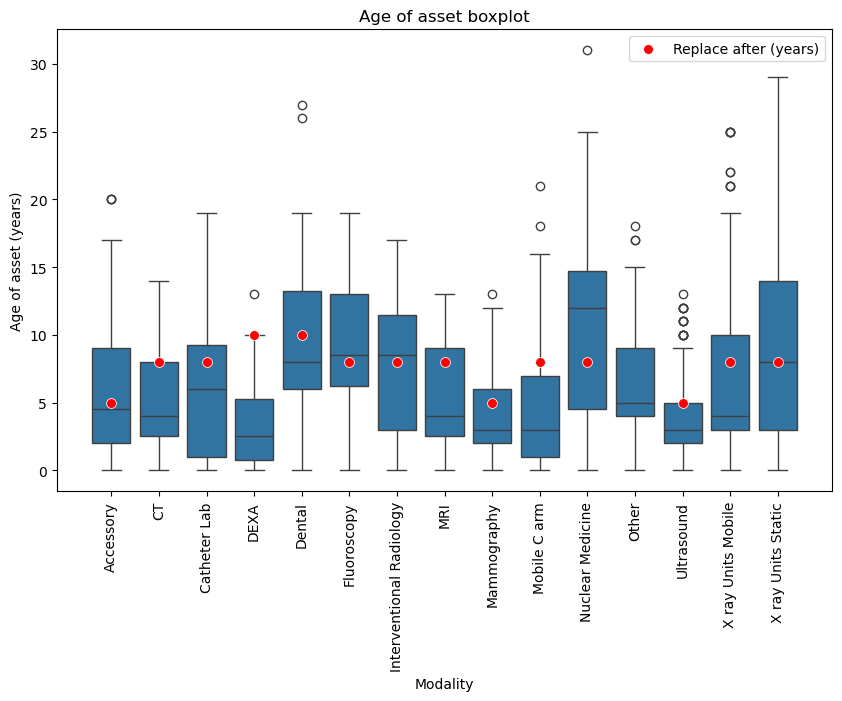

In [86]:
# Calculate avg replacement age (for scatter plot purpose)
average_replacement_schedule = df.groupby('Modality_Der')['replacement_schedule'].mean().reset_index()

# Sort data by Modality_Der alphabetically
df['Modality_Der'] = pd.Categorical(df['Modality_Der'], categories=sorted(df['Modality_Der'].unique()), ordered=True)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot boxplot
sns.boxplot(x='Modality_Der', 
            y='Age', 
            data=df, 
            ax=ax, 
            zorder=1)

# Filter out zeros and NaNs for plotting red dots
plot_data = average_replacement_schedule[
    average_replacement_schedule['replacement_schedule'] > 0].dropna()

# Rotate x labels
plt.xticks(rotation=90)

# Plot replacement schedule as red dots
sns.scatterplot(x='Modality_Der', 
                y='replacement_schedule', 
                data=plot_data, 
                color='red', 
                s=50, 
                marker='o', 
                ax=ax, 
                label='Replace after (years)',
                zorder=2
                )

# Set plot title and labels
ax.set_xlabel("Modality")
ax.set_ylabel("Age of asset (years)")
ax.set_title("Age of asset boxplot")

# Show plot
plt.show()

In [109]:
# bring in population by ICB data
org_pop = {
'RTK': 305788,
'RXQ': 402331,
'RN7': 286294,
'RVV': 649593,
'RXC': 340058,
'RDU': 747635,
'RN3': 354829,
'RN5': 441864,
'R1F': 118677,
'RWF': 483060,
'RPA': 321403,
'RTH': 832002,
'RHU': 577919,
'RPC': 151985,
'RHW': 450622,
'RA2': 330330,
'RHM': 639804,
'RYR': 969329,
'RTP': 347182,
'RW1': 500000 #### PLACEHOLDER, NEEDS CHANGING
}

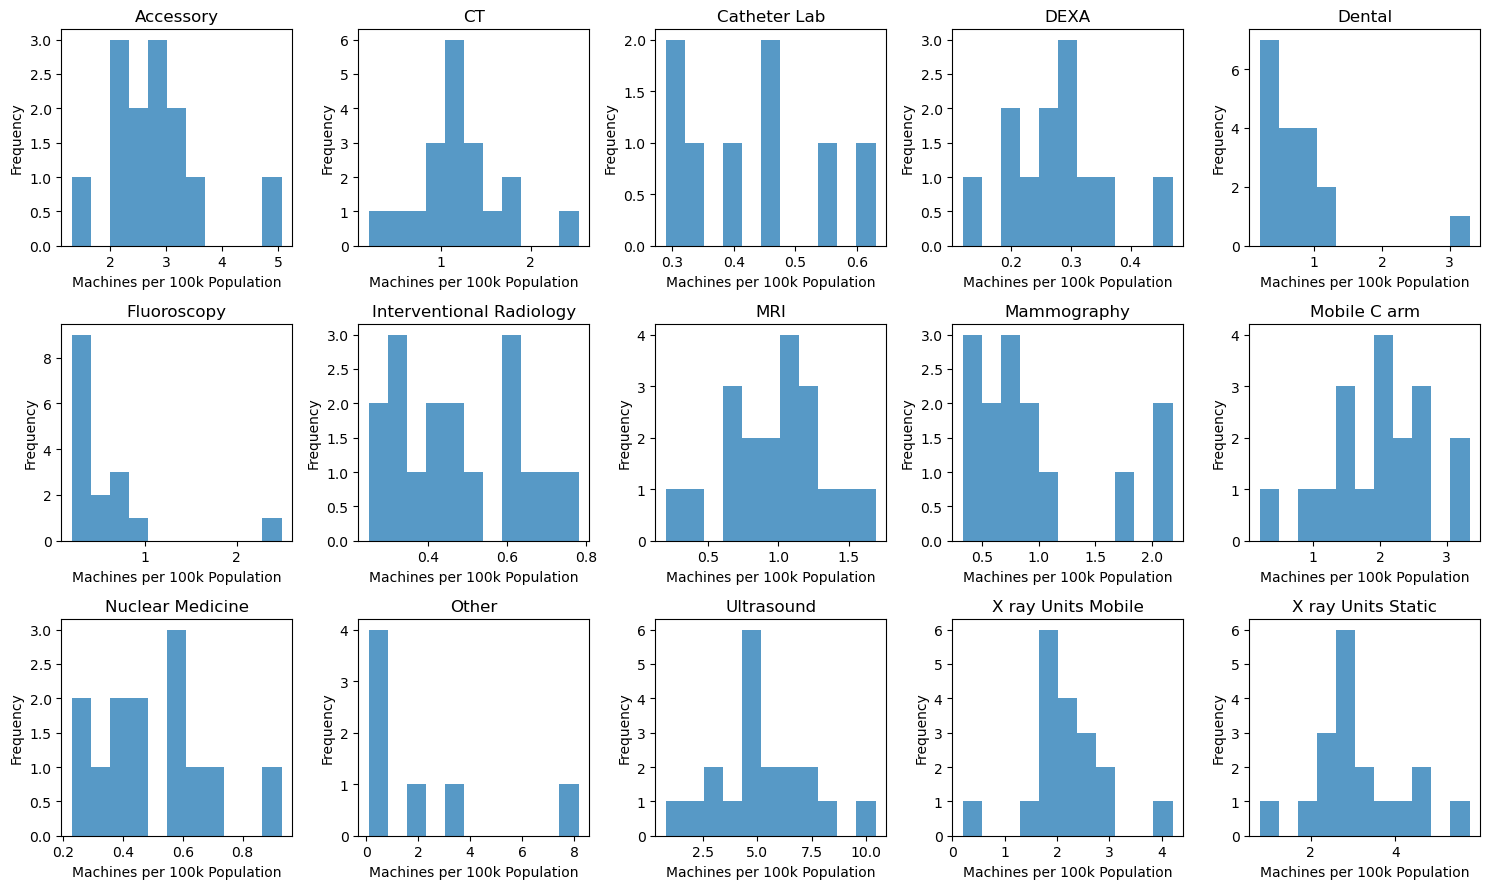

In [194]:
# create by 100k pop analysis

# Group data by org and modality
df_pop = df.groupby(['OrganisationCode', 'Modality_Der']).count().reset_index()

# Add pop data to the DataFrame
df_pop['org_pop'] = df_pop.apply(lambda row: org_pop[(row['OrganisationCode'])], axis=1)

# Drop columns and tidy up names
df_pop = df_pop[['OrganisationCode', 'Modality_Der', 'OrganisationName', 'org_pop']]
df_pop = df_pop.rename(columns={'OrganisationName': 'count'})

# Create calculated field for machines by pop, then pivot
df_pop['machines_per_100k_pop'] = round(df_pop['count'] / (df_pop['org_pop'] / 100000), 2)

# Plot histograms, one for each Modality_Der
modalities = sorted(df_pop['Modality_Der'].unique())
num_modalities = len(modalities)
num_cols = 5
num_rows = (num_modalities + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for idx, modality in enumerate(modalities):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]
    subset = df_pop[df_pop['Modality_Der'] == modality]
    ax.hist(subset['machines_per_100k_pop'], bins=11, alpha=0.75)
    ax.set_title(f'{modality}')
    ax.set_xlabel('Machines per 100k Population')
    ax.set_ylabel('Frequency')

plt.tight_layout()
